In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
import os
import copy
import pathlib
import time

import numpy as np
import matplotlib.pyplot as plt
import scipy

import torch
import torchvision
import torchvision.transforms as transforms

# for creating validation set
from sklearn.model_selection import train_test_split

%matplotlib notebook
%matplotlib notebook
# %matplotlib inline
# %matplotlib qt

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# !git clone "https://github.com/RichieHakim/basic_neural_processing_modules.git" "/content/drive/MyDrive/00 - ROI/basic_neural_processing_modules"

In [4]:
# !pip install pycuda

In [5]:
import sys

sys.path.append(r'/media/rich/Home_Linux_partition/github_repos')
# sys.path.append('/Users/Josh/Documents/github_repos/')
# sys.path.append(r'/content/drive/MyDrive/00 - ROI')
# dir_folders = r'/content/drive/MyDrive/00 - ROI/label_data'


%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import torch_helpers, decomposition, classification, math_functions
from GCaMP_ROI_classifier.old_stuff import util, models, training_simCLR, augmentation, training_classHead

## Import training data

In [6]:
import pickle

# with open('/content/drive/MyDrive/00 - ROI/label_data/all_stat_files_20211022.pkl', 'rb') as file:
# with open('/Users/Josh/Documents/Harvard/label_data/all_stat_files_20211022.pkl', 'rb') as file:
with open('/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data/all_stat_files_20211022.pkl', 'rb') as file:
    statFiles_scraped = pickle.load(file)

In [7]:
keys_toDelete = [
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\16x_analysis20200514\\Suite2p and MC for denoised movie\\suite2p\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\round 4 experiments\\mouse 6.28\\20201102\\suite2p_accidentally_run_on_everything\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attemp 2 _tau 1_5\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attempt 1 _tau 2\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attempt 3 _tau 1\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\AAV\\oldBMIrampExp_20191112_mouse1013A\\ROI extraction\\suite2p\\plane0\\stat.npy',
]
for key in keys_toDelete:
    del statFiles_scraped[key]

In [8]:
# keys_toDelete = list(statFiles_scraped.keys())[:len(statFiles_scraped.keys())]
keys_toDelete = list(statFiles_scraped.keys())[2:]
for key in keys_toDelete:
    del statFiles_scraped[key]

In [9]:
sf_list = util.convert_multiple_stat_files(statFiles_dict=statFiles_scraped, out_height_width=[36,36], max_footprint_width=901, plot_pref=False)

# images_all = np.concatenate(sf_list, axis=0)
images_all = np.concatenate([sf_list[ii][:1000] for ii in range(len(sf_list))], axis=0)

images_all.shape

(1659, 36, 36)

In [10]:
images_all_norm = (images_all / np.max(images_all, axis=(1,2), keepdims=True)) * 1

In [11]:
# create validation set
# X_train, X_val, y_train, y_val = train_test_split(images[:], labels[:], test_size = 0.15)
X_train, X_val, y_train, y_val = train_test_split(images_all_norm, np.arange(images_all.shape[0]), test_size = 0.15)
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape)

(((1410, 36, 36), (1410,)), ((249, 36, 36), (249,)))

<IPython.core.display.Javascript object>


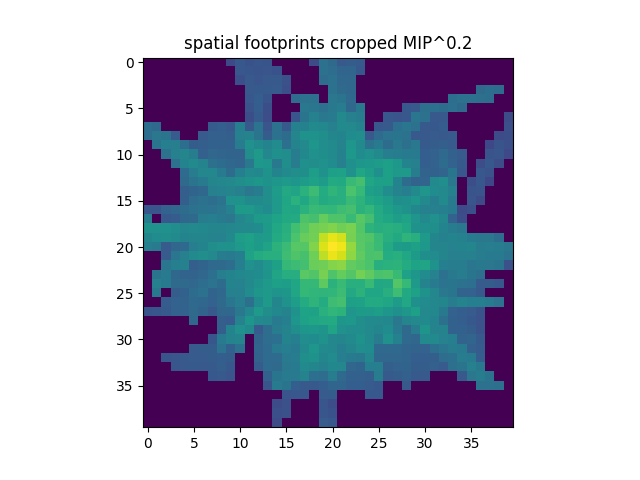

<IPython.core.display.Javascript object>


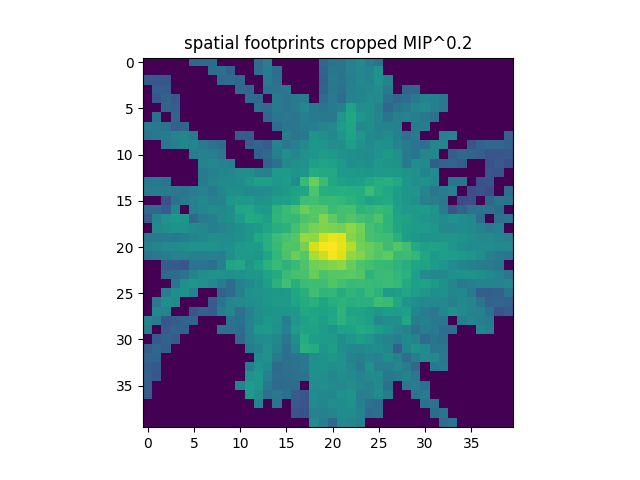

concatenated images shape: (9715, 40, 40)


<IPython.core.display.Javascript object>


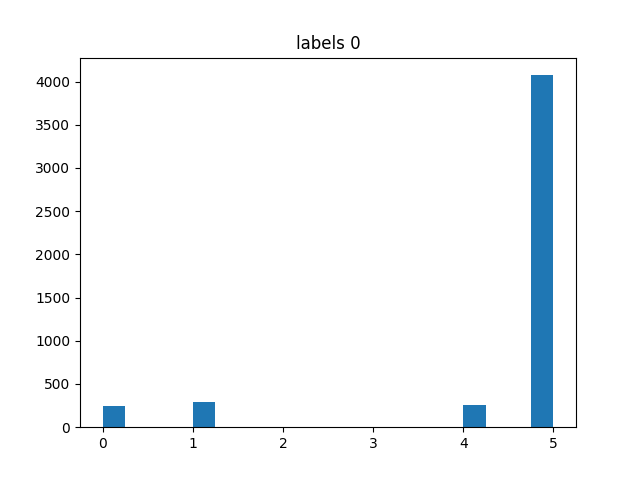

<IPython.core.display.Javascript object>


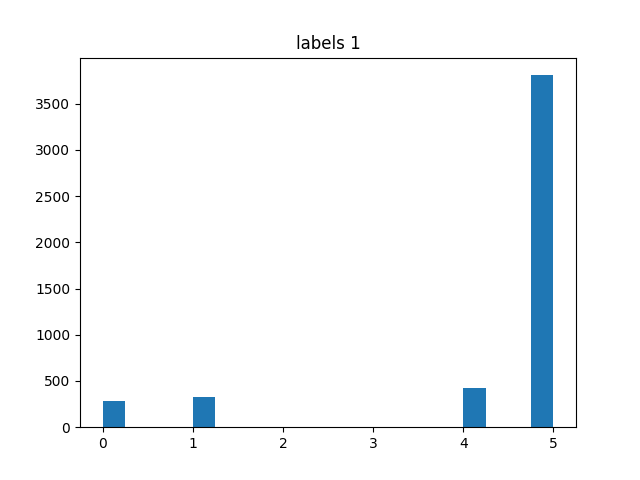

In [13]:
# dir_folders = r'/content/drive/MyDrive/00 - ROI/label_data'
dir_folders = r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data'
# dir_folders = r'/users/Josh/Documents/Harvard/label_data'
folders = [r'mouse 6_28 _ day 20200903/',
             r'mouse6_28 _ day20200815/']
fileNames_statFiles = [r'stat.npy']*len(folders)
paths_statFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_statFiles[ii] for ii in range(len(folders))]

statFile_import_kwargs = {'out_height_width': [40,40],
                          'max_footprint_width': 241,
                          'plot_pref':True}

sf_all = util.import_multiple_stat_files(   paths_statFiles=paths_statFiles,
                                        fileNames_statFiles=fileNames_statFiles,
                                        out_height_width=[40,40],
                                        max_footprint_width=241,
                                        plot_pref=True)
images_labeled = np.concatenate(sf_all, axis=0)
images_labeled = (images_labeled / np.max(images_labeled, axis=(1,2), keepdims=True)) * 1
print(f'concatenated images shape: {images_labeled.shape}')

fileNames_labelFiles = ['labels_posthoc_filledIn_allCells.npy',
             'labels_posthoc_all.npy']
paths_labelFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_labelFiles[ii] for ii in range(len(folders))]

labels_all = util.import_multiple_label_files(paths_labelFiles=paths_labelFiles,
                                       plot_pref=True)
labels = np.concatenate(labels_all)

assert np.alltrue([sf_all[ii].shape[0] == labels_all[ii].shape[0] for ii in range(len(sf_all))]) , 'num images in stat files does not correspond to num labels'

In [14]:
# tmpd = pd.DataFrame(labels)
# tmpd[1] = tmpd[0]
# tmpd.groupby(0).count()

In [15]:
#code doesn't work with multiple open number maybe (?)

In [16]:
labels = classification.squeeze_integers(labels)
images_labeled = images_labeled[labels != 2]
labels = labels[labels != 2]
labels = classification.squeeze_integers(labels)

In [17]:
# images_labeled = images_labeled[labels!=3]
# labels = labels[labels!=3]


## Balance classes of inputs

In [18]:
duplicates = 1

images_dup = np.tile(images_labeled , (duplicates , 1 , 1))
labels_dup = np.tile(labels , (duplicates))

print(images_dup.shape)
print(labels_dup.shape)

numToGetTo = np.sum(labels_dup==0)
print(numToGetTo)

print(np.sum(labels_dup==0))
print(np.sum(labels_dup==1))
print(np.sum(labels_dup==4))
print(np.sum(labels_dup==5))
print(images_dup.shape)
print(labels_dup.shape)

(9714, 40, 40)
(9714,)
532
532
620
0
0
(9714, 40, 40)
(9714,)


In [19]:
# create validation set

###### REMOVE WITH ENOUGH RAM
images = images_dup
labels = labels_dup

# X_train, X_val, y_train, y_val = train_test_split(images[:], labels[:], test_size = 0.15)
X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.15)
X_train, X_val, y_train, y_val = X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val
(X_labeled_train.shape, y_labeled_train.shape), (X_labeled_val.shape, y_labeled_val.shape)

(((8256, 40, 40), (8256,)), ((1458, 40, 40), (1458,)))

In [20]:
# # create validation set
# # X_train, X_val, y_train, y_val = train_test_split(images[:], labels[:], test_size = 0.15)
# X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup[labels!=3], labels_dup[labels!=3], test_size = 0.15)
# (X_labeled_train.shape, y_labeled_train.shape), (X_labeled_val.shape, y_labeled_val.shape)

<IPython.core.display.Javascript object>


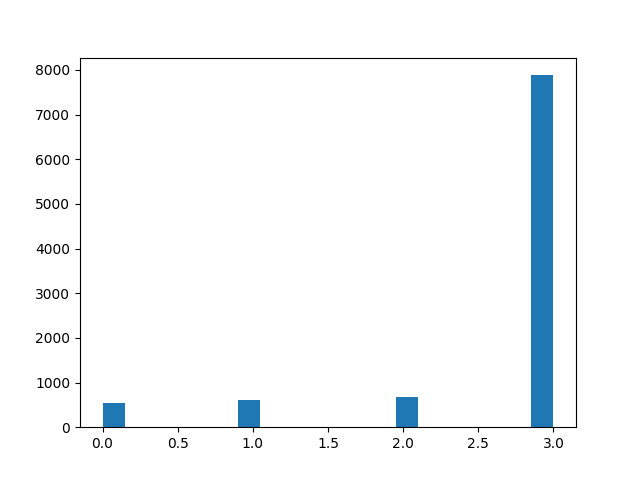

In [21]:
plt.figure()
plt.hist(labels_dup, 20);

## Define augmentation pipeline

In [22]:
X_train.shape

(8256, 40, 40)

In [94]:
import torchvision.transforms    

transforms = torch.nn.Sequential(
    
######     torchvision.transforms.RandomAdjustSharpness(torch.rand(1)*5, p=0.5),
    
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
        
    torchvision.transforms.GaussianBlur(kernel_size=5,
                                        sigma=(0.0001, 0.5)),
    
    torchvision.transforms.RandomPerspective(distortion_scale=0.4, 
                                             p=0.5, 
                                             interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
                                             fill=0),
    torchvision.transforms.RandomAffine(
                                        degrees=(-180,180),
                                        translate=(0.3, 0.3),
                                        scale=(0.7, 1.7), 
                                        shear=(-20, 20, -20, 20), 
                                        interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
                                        fill=0, 
                                        fillcolor=None, 
                                        resample=None),
    
    augmentation.AddPoissonNoise(   scaler_bounds=(20, 100),
                                    prob=1,
                                    base=50,
                                    scaling=''),

    augmentation.AddGaussianNoise(  mean=0, 
                                    std=0.07,
                                    prob=1),
)
scripted_transforms = torch.jit.script(transforms)
# scripted_transforms = transforms



dataset_train = util.dataset_simCLR(
                                    X_train, 
                                    y_train, 
#                                     torch.tensor(X_train), 
#                                     y_train, 
                                    n_transforms=2, 
#                                     class_weights=[1]*4,
#                                     class_weights=[0.34, 0.33, 0.33, 0.00],
#                                     class_weights=[0.0, 0.0, 0.0, 1.00],
#                                     class_weights=np.array([0.34, 0.33, 0.33, 0.00])[y_train],
#                                     class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms,
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64 )

dataloader_train = torch.utils.data.DataLoader( dataset_train,
                                                batch_size=4096,
            #                                     sampler=sampler,
                                                shuffle=True,
                                                drop_last=True,
                                                pin_memory=True,
#                                                 num_workers=0,
                                                num_workers=32,
#                                                 prefetch_factor=0,
#                                                 persistent_workers=True,
                                                )

# dataset_val = util.dataset_simCLR(torch.tensor(X_val), 
#                                     y_val, 
#                                     n_transforms=2, 
#                                     transform=scripted_transforms,
#                                     DEVICE='cpu',
#                                     dtype_X=torch.float32,
#                                     dtype_y=torch.int64 )

# dataloader_val = torch.utils.data.DataLoader(   dataset_val,
#                                                 batch_size=128,
#             #                                     sampler=sampler,
#                                                 shuffle=True,
#                                                 drop_last=True,
#                                                 pin_memory=True,
#                                                 num_workers=0,
#                                                 )         

1


<IPython.core.display.Javascript object>


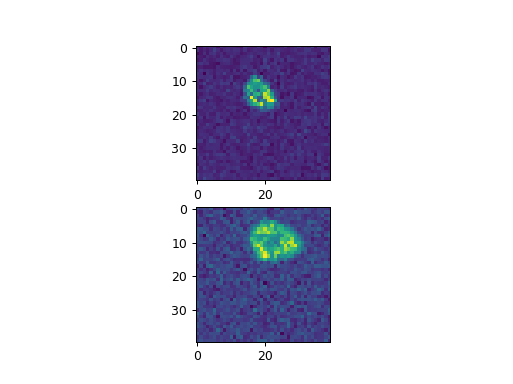

1


<IPython.core.display.Javascript object>


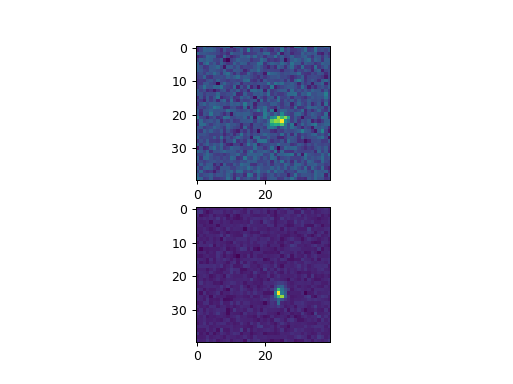

1


<IPython.core.display.Javascript object>


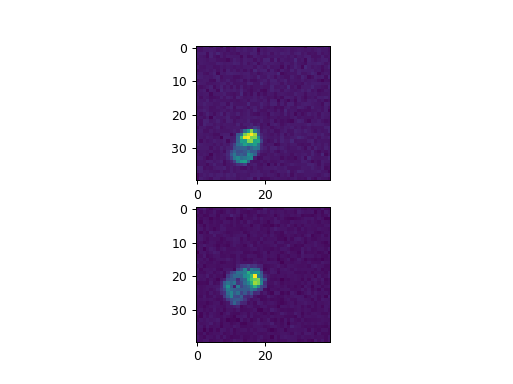

1


<IPython.core.display.Javascript object>


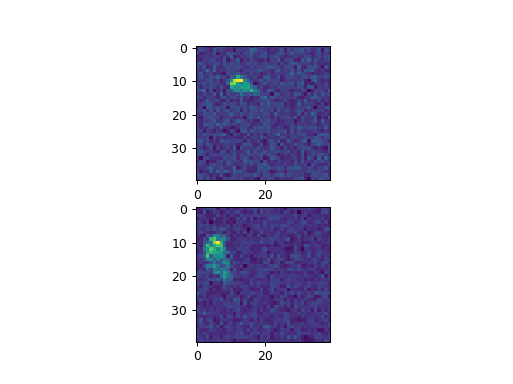

1


<IPython.core.display.Javascript object>


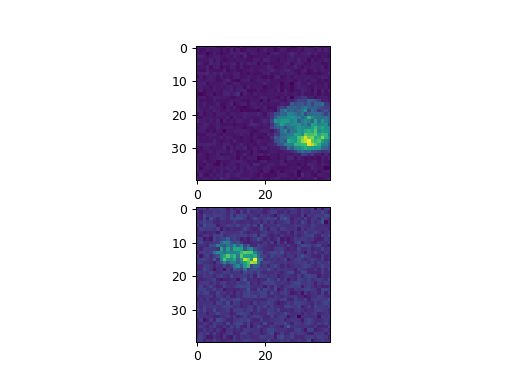

In [95]:
import time

%matplotlib notebook
tic=time.time()
for idx in range(5):
# for ii,idx in enumerate(np.random.randint(0,X_train.shape[0], 5)):
#     for jj in range(im[0])
#     print(time.time() - tic)
#     tic = time.time()
#     print((im[0][0]).shape)
    print(dataset_train[idx][3])
    fig, axs = plt.subplots(2)
    for jj, ax in enumerate(axs):
#         ax.imshow(im[0][j].cpu().squeeze())
#         ax.imshow(dataset_train[idx][0][jj][0].permute(1,2,0).cpu().squeeze()/20)
        im_toShow = dataset_train[idx][0][jj][0].cpu().squeeze()
        ax.imshow(im_toShow)
#     if ii > 5:
#         break

## Train

In [30]:
DEVICE = torch_helpers.set_device(use_GPU=True)

device: 'cuda'


In [31]:
import torchvision.models

model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False


# for param in model.layer3.parameters():
#     param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.avgpool.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

In [32]:
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix


# model = models.LeNet1(dropout_prob=0.3, momentum_val=0, n_output_features=64)


# criterion = CrossEntropyLoss()
criterion = CrossEntropyLoss(reduction='none')

optimizer = Adam(model.parameters(), lr=2e-3, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.0002,
#                                                    gamma=1,
                                                  )
# val_obj = training_simCLR.validation_Obj(   X_val,
#                                             y_val,
#                                             model,
#                                             criterion,
#                                             DEVICE=DEVICE,
#                                             dtype_X=torch.float32,
#                                             dtype_y=torch.int64) # Needs to take in weights

model.to(DEVICE)
criterion = criterion.to(DEVICE)

# # classHead = HeadModel(model, RandomForestClassifier)
# classHead = training_classHead.HeadModel(model, LogisticRegression)
# dataset_train.headmodel = classHead
# # dataset_train.headmodel = None

losses_train, losses_val, val_accs, acc = [], [np.nan], [], []

In [62]:
import pandas as pd
tracking_df_cols = ['sample_id',
                    'epoch',
                    'batch_iter',
                    'labels'
                    ]
tracking_df = pd.DataFrame(columns=tracking_df_cols)

In [34]:
%matplotlib notebook

logreg = LogisticRegression(solver='liblinear')
logreg_predict_head = LogisticRegression(solver='liblinear')
dataset_train.classification_model = None

# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
#                                                    gamma=1-0.001,
# #                                                    gamma=1,
#                                                   )
n_epochs=300000
for epoch in range(n_epochs):
    print(f'epoch: {epoch}')
    training_simCLR.epoch_step( dataloader_train, 
                                model, 
                                optimizer, 
                                criterion, 
                                scheduler=scheduler, 
                                temperature=0.5,
                                loss_rolling_train=losses_train, 
                                device=DEVICE, 
                                do_validation=False,
#                                 validation_Object=val_obj,
                                loss_rolling_val=losses_val,
                                verbose=2,
                                verbose_update_period=100,
                               )
    

    features_train = model(torch.as_tensor(util.expand_channels(X_labeled_train), device=DEVICE, dtype=torch.float32)).detach().cpu()
    # features_train = model(torch.as_tensor(X_labeled_train, device=DEVICE, dtype=torch.float32)[:,None,...]).detach().cpu()
    # features = model(torch.tensor(X_train[y_train != 3], device=DEVICE, dtype=torch.float32)[:,None,...]).detach().cpu()
    logreg.fit(features_train, y_labeled_train)
    acc.append(logreg.score(features_train, y_labeled_train))
    print(f'acc: {acc[-1]}')
    
    dataset_train.net_model = copy.deepcopy(model).to('cpu')
    dataset_train.classification_model = logreg
    

#     sample_id_num = np.arange(X_labeled_val.shape[0])
#     epoch_val = epoch
#     batch_val = -1
#     p_tmp = logreg.predict_proba(model(torch.as_tensor(util.expand_channels(X_labeled_val), device=DEVICE, dtype=torch.float32)).detach().cpu())
#     logits = p_tmp
#     # logits = np.log(1/(1/p_tmp - 1))

#     col_vals = [sample_id_num, epoch_val, batch_val, y_labeled_val]
#     setup = np.empty((len(sample_id_num), len(col_vals)))
#     for icv, col_val in enumerate(col_vals):
#       setup[:, icv] = col_val
#     tmp_tracking_np = np.concatenate([setup, logits], axis=1)

#     tmp_tracking_df = pd.DataFrame(tmp_tracking_np, index=sample_id_num, columns=tracking_df_cols + [f'logits_{i}' for i in range(logits.shape[1])])
#     tracking_df = tracking_df.append(tmp_tracking_df, ignore_index=True)
#     display(tracking_df)



    features_val = model(torch.as_tensor(util.expand_channels(X_labeled_val), device=DEVICE, dtype=torch.float32)).detach().cpu()


    # logreg_predict_head.fit(features_train, y_labeled_train)
    # y_hat = logreg_predict_head.predict_proba(features_val)

    y_hat = logreg.predict_proba(features_val)
    
    cm = classification.confusion_matrix(y_hat, y_labeled_val)
#     plt.figure()
#     plt.imshow(cm)
#     plt.colorbar()
#     plt.show()
    print(cm)


    # tracking_df = tracking_df.append(pd.DataFrame([np.array([100, 0, 0, 0])], index=tracking_df_cols), ignore_index=True)
    
    # model predict
    # Update model in DS
    # get item calls model for each sample
    # output
    # X sample weights predictions
    
#     classHead.fit(X_train[:, None, :, :], y_train, solver='liblinear')
    
#     proba = classHead.predict_proba(X_train[:, None, :, :])
#     class_weights = proba.sum(axis=0)
#     total_num = class_weights.sum()
    
#     eps = 1e-4
    
#     class_weights[class_weights <= 3] = total_num
#     weightings = class_weights.sum()/class_weights
#     final_weights = weightings / weightings.sum()
#     final_weights = np.array([1/proba.shape[1] for _ in range(proba.shape[1])])
    
#     print(class_weights)

#     dataset_train.set_classweights(final_weights)
    
#     print('dataset_train.final_weights', dataset_train.class_weights)


epoch: 0


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 7, 7], but got 5-dimensional input of size [8192, 1, 3, 40, 40] instead

In [67]:
2

In [38]:
features_train.shape

torch.Size([8256, 1000])

In [39]:
    tic = time.time()    
    logreg.fit(features_train, y_labeled_train)
    print(time.time() - tic)

29.547704219818115


In [15]:
# !cd "/content/drive/MyDrive/00 - ROI/GCaMP_ROI_classifier" && git add old_stuff
# !cd "/content/drive/MyDrive/00 - ROI/GCaMP_ROI_classifier" && git status
# !cd "/content/drive/MyDrive/00 - ROI/GCaMP_ROI_classifier" && git commit -m "Introducing ResNet and validating process"
!cd "/content/drive/MyDrive/00 - ROI/GCaMP_ROI_classifier" && git push

fatal: could not read Username for 'https://github.com': No such device or address


In [14]:
!git config --global user.email "$indianajonesjz@gmail.com"
!git config --global user.name "$joshuazimmer"

In [ ]:
plt.figure()
plt.plot(losses_train)

In [ ]:
plt.figure()
plt.plot(losses_train)

In [ ]:
%matplotlib inline
plt.figure()
plt.plot(losses_train)

In [ ]:
%matplotlib inline
plt.figure()
plt.plot(losses_train)

In [ ]:
plt.figure()
plt.plot(acc)

In [ ]:
features_train = model(torch.as_tensor(X_labeled_train, device=DEVICE, dtype=torch.float32)[:,None,...]).detach().cpu()
# features = model(torch.tensor(X_train[y_train != 3], device=DEVICE, dtype=torch.float32)[:,None,...]).detach().cpu()
logreg.fit(features_train, y_labeled_train)
y_hat = logreg.predict_proba(features_train)
cm = rh_cm(y_hat, y_labeled_train)

print(cm)

plt.figure()
plt.imshow(cm)
plt.colorbar()

In [ ]:
proba = classHead.predict_proba(dataset_train.X)

In [ ]:
# classHead.fit(X_train[:, None, :, :], y_train)



proba = classHead.predict_proba(X_train[:, None, :, :])
final_weights = np.array([1/proba.shape[1] for _ in range(proba.shape[1])])

dataset_train.set_classweights(final_weights)


In [ ]:
%load_ext autoreload
%autoreload 2

from basic_neural_processing_modules import decomposition

In [ ]:
logreg = LogisticRegression(solver='liblinear')
head = classHead.get_simCLR_head(X_train[:, None, ...])
# head = classHead.norm_head(head)
# head = head[:, [_ for _ in range(64) if _ not in [7, 15, 20, 21, 36, 54, 57, 60, 61, 62, 63, 64]]]
components , scores , decomposition.explained_variance_ratio_ , stds = decomposition.simple_pca(head, n_components=None)

# logreg.fit(scores[:, :], y_train)
# logreg.predict_proba(scores[:, :])
logreg.fit(head, y_train)
logreg.predict_proba(head)

In [ ]:
prd = logreg.predict_proba(head)
# prd = logreg.predict_proba(scores[:, :2])
plt.figure()
# plt.plot(logreg.predict_proba(scores[:, :2]))
plt.plot(logreg.predict_proba(head))

In [ ]:
# cm = confusion_matrix(y_train, np.argmax(logreg.predict_proba(scores[:, :2]), axis=1))
cm = confusion_matrix(y_train, np.argmax(logreg.predict_proba(head), axis=1))
cm = np.round(cm/cm.sum(axis=0), 2)
cm

In [ ]:
logreg.predict_proba(classHead.get_simCLR_head(X_val[:, None, :, :]))

In [ ]:
classHead.fit(X_train[:, None, :, :], y_train)

In [ ]:
classHead.predict_proba(X_train[:, None, :, :])

In [ ]:
idx_sample = 5
classHead.predict_proba(X_train[idx_sample:idx_sample+1, None, ...])

In [ ]:
sample_weight = util.loss_uncertainty(torch.as_tensor(proba), temperature=1, class_value=dataset_train.class_weights)

## Check embeddings

In [ ]:
torch.cuda.empty_cache()

In [ ]:
features = model(torch.tensor(images_labeled, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
# features = model(torch.tensor(images_labeled[labels != 3], device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
# features = model(torch.tensor(X_val, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
# features = model(torch.tensor(X_train, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()

In [ ]:
_, features_embedded, _, _ = decomposition.torch_pca(features, device=DEVICE, return_cpu=True)

In [ ]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, 
                     perplexity=80.0, 
                     early_exaggeration=12.0, 
                     learning_rate=200, 
                     n_iter=1000, 
                     n_iter_without_progress=300, 
                     min_grad_norm=1e-07, 
                     metric='euclidean', 
                     init='pca', 
                     verbose=0, 
                     random_state=None, 
                     method='barnes_hut', 
                     angle=0.5, 
                     n_jobs=-1, 
#                      square_distances='legacy'
                    )
features_embedded = tsne.fit_transform(features.cpu())

In [ ]:
import matplotlib as mpl

# mpl.rcParams['image.cmap'] = 'Set1'
%matplotlib notebook
plt.figure()
plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels)
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels[labels!=3])
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y_val)
# plt.scatter(features_embedded[:,4], features_embedded[:,5], c=y_train)
# plt.scatter(features_embedded[:,11], features[:,43].cpu(), c=y_train)
mpl.rcParams['image.cmap'] = 'viridis'


In [ ]:
plt.figure()
plt.imshow(features.cpu().detach(), aspect='auto', interpolation='none')

## Check filters

In [ ]:
list(model.state_dict().keys())

In [ ]:
layer_1 = model.state_dict()['cnn_layers.0.weight'].cpu()
layer_2 = model.state_dict()['cnn_layers.2.weight'].cpu()
layer_3 = model.state_dict()['cnn_layers.5.weight'].cpu()
layer_4 = model.state_dict()['cnn_layers.8.weight'].cpu()

plt.figure()
for ii in range(layer_1.shape[1]):
    for jj in range(layer_1.shape[0]):
        plt.subplot2grid((layer_1.shape[1],layer_1.shape[0]),(ii,jj))
        fig = plt.imshow(layer_1[jj,ii,:,:] , clim=(-0.2,0.2))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(layer_2.shape[1]):
    for jj in range(layer_2.shape[0]):
        plt.subplot2grid((layer_2.shape[1],layer_2.shape[0]),(ii,jj))
        fig = plt.imshow(layer_2[jj,ii,:,:], clim=(-.05,.05))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_3[jj, ii,:,:])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_4[jj, ii,:,:])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

In [ ]:
# torch.save(model.state_dict(), '/media/rich/bigSSD/Net_trainedOnAug_20211025_trainingSet_mouse628_20200903and20200815_simCLR.pth')

In [ ]:
# model = Net()
# model.load_state_dict(torch.load('test_save.pth'))
# model.eval()